In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
train_set, test_set = mnist_data_lib.load_mnist_data()

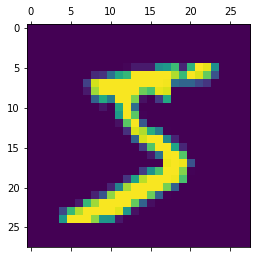

In [3]:
plt.matshow(train_set.train_data[0])

In [4]:
slen = train_set.train_data[0].shape[0]

# Get data loaders

In [5]:
batchsize = 20

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader):
    data = d
    break

# Define VAE

In [7]:
latent_dim = 5
n_classes = 10

In [8]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [9]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae_enc_final"
dec_file = '../mnist_vae_results_aws/mnist_vae_dec_final'

vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=19, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=1568, bias=True)
  )
)

In [10]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=19, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=1568, bias=True)
  )
)>


In [23]:
latent_means, latent_std, latent_samples, class_weights = \
            vae.encoder_forward(data[0])

In [24]:
latent_means

tensor(1.00000e-02 *
       [[ 0.5696,  0.3213, -0.1933, -0.4892, -0.0272],
        [ 0.3313, -1.1851,  1.1198, -0.7523, -1.6754],
        [ 1.0485, -0.6138,  1.2252, -0.1321, -1.0327],
        [ 0.2498, -0.4777,  1.2095, -0.4127, -0.7255],
        [-0.5650,  0.1522,  0.0756, -1.5688, -0.4521],
        [ 0.9940, -0.2904,  0.3731, -0.3081, -1.3588],
        [ 0.9852, -0.6018,  0.6824,  1.0933, -0.7458],
        [ 0.4508, -0.8708, -0.1019,  0.3532, -0.0779],
        [ 0.3123, -1.0131, -0.1414,  0.4708, -2.0110],
        [ 1.5345, -0.1938,  0.9013,  1.2407,  0.4320],
        [ 1.2451, -0.5528, -0.1080,  1.5408, -0.5895],
        [ 0.7671,  0.4189,  1.1875, -0.2196,  0.5911],
        [ 1.4290, -1.9096,  1.7853,  1.2548, -2.1458],
        [ 1.2213, -3.2182,  1.7027,  0.0418, -1.9699],
        [ 0.1524, -0.2636, -0.2069, -0.5272, -1.5212],
        [ 0.8294, -0.2593, -0.1290,  0.9315,  1.2103],
        [ 0.7321, -1.3258,  0.7284,  0.5430, -0.3883],
        [ 1.1243, -0.2951,  0.6075,  0.2564,

In [31]:
loss = 0.0
for z in range(vae.encoder.n_classes):
    batch_z = torch.ones(data[0].shape[0]) * z
    image_mu, image_std = vae.decoder_forward(latent_samples, batch_z)

    normal_loglik_z = common_utils.get_normal_loglik(data[0], image_mu,
                                            image_std, scale = False)
    if not(np.all(np.isfinite(normal_loglik_z.detach().cpu().numpy()))):
        print(z)
        print(image_std)
        assert np.all(np.isfinite(normal_loglik_z.detach().cpu().numpy()))

    foo = - (class_weights[:, z] * normal_loglik_z).sum()
    print(foo)

tensor(1.00000e-35 *
       8.1269)
tensor(1.00000e-02 *
       1.3384)
tensor(54366.6758)
tensor(54562.8555)
tensor(53708.2734)
tensor(55774.2109)
tensor(54277.6133)
tensor(53994.0234)
tensor(53651.0195)
tensor(-0.)


In [12]:
trainloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=train_set, 
                                                       propn_sample=0.001)

testloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=test_set, 
                                                       propn_sample=0.001)

In [13]:
vae.eval_vae(trainloader_subs)

log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9458)
log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9458)
log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9457)
log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9457)
log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9458)
log like tensor(-0.)
kl q latent tensor(43.5519)
kl q z tensor(-1.9457)


tensor(1.00000e-02 *
       4.1606)

In [14]:
vae.eval_vae(testloader_subs)

log like tensor(-0.)
kl q latent tensor(43.5522)
kl q z tensor(-1.9457)


tensor(1.00000e-02 *
       4.1606)

In [15]:
latent_means, latent_std, latent_samples, class_weights = \
    vae.encoder_forward(data[0])

In [21]:
class_weights

tensor([[ 0.0000,  0.0000,  0.1442,  0.1426,  0.1440,  0.1463,  0.1428,
          0.1410,  0.1391,  0.0000],
        [ 0.0000,  0.0000,  0.1446,  0.1431,  0.1394,  0.1465,  0.1441,
          0.1426,  0.1398,  0.0000],
        [ 0.0000,  0.0000,  0.1386,  0.1467,  0.1414,  0.1460,  0.1435,
          0.1424,  0.1413,  0.0000],
        [ 0.0000,  0.0000,  0.1438,  0.1432,  0.1425,  0.1461,  0.1426,
          0.1424,  0.1395,  0.0000],
        [ 0.0000,  0.0000,  0.1440,  0.1425,  0.1400,  0.1451,  0.1442,
          0.1430,  0.1411,  0.0000],
        [ 0.0000,  0.0000,  0.1432,  0.1453,  0.1419,  0.1461,  0.1425,
          0.1411,  0.1399,  0.0000],
        [ 0.0000,  0.0000,  0.1399,  0.1447,  0.1413,  0.1468,  0.1417,
          0.1428,  0.1428,  0.0000],
        [ 0.0000,  0.0000,  0.1424,  0.1428,  0.1434,  0.1489,  0.1423,
          0.1415,  0.1388,  0.0000],
        [ 0.0000,  0.0000,  0.1434,  0.1465,  0.1388,  0.1475,  0.1409,
          0.1420,  0.1410,  0.0000],
        [ 0.0000,  

In [16]:
latent_std

tensor(1.00000e-23 *
       [[ 0.0000,  0.0011,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0062,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0016,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0005,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1460,  0.0000,  0.0005,  0.0000],
        [ 0.0000,  0.0004,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.2463,  0.0000,  0.0163,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0119,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0315,  0.0000,  0.0001,  0.0000],
        [ 0.0000,  0.0043,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0067,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0280,  0.0000,  0.0001,  0.0000],
        [ 0.0000,  0.0001,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0687,  0.0000,  0.0046,  0.0000],
        [ 0.0000,  0.0001,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0203,  0.0000,  0.0001,

In [17]:
z_ind = torch.argmax(class_weights, dim = 1)

one_hot_z = common_utils.get_one_hot_encoding_from_int(z_ind, vae.encoder.n_classes)

In [18]:
one_hot_z

tensor([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  

In [19]:
image_mean, image_std = vae.decoder(latent_samples, one_hot_z)

(array([  47., 1389., 3199., 2740., 2855., 2921., 2404.,   85.,   20.,
          20.]),
 array([1.08411908, 1.10362318, 1.12312727, 1.14263136, 1.16213546,
        1.18163955, 1.20114365, 1.22064774, 1.24015183, 1.25965593,
        1.27916002]),
 <a list of 10 Patch objects>)

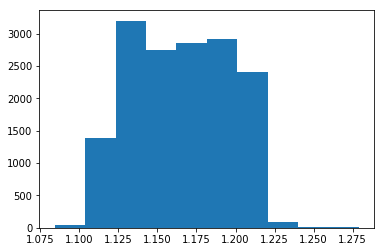

In [69]:
plt.hist(image_std.detach().numpy().flatten())

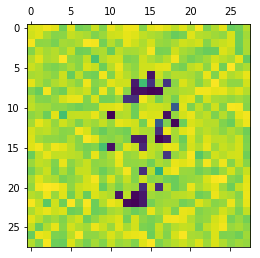

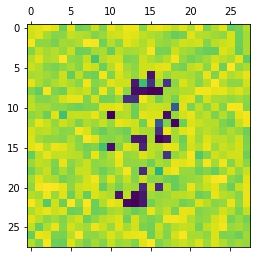

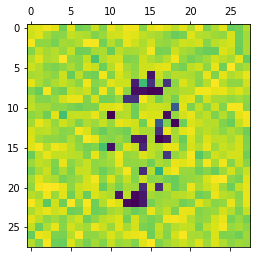

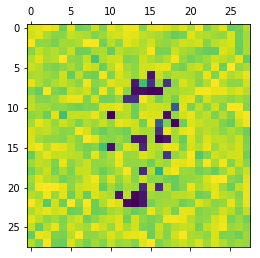

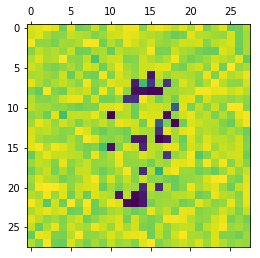

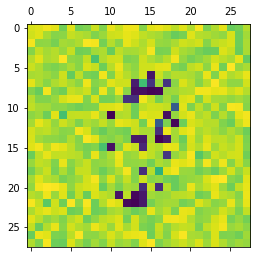

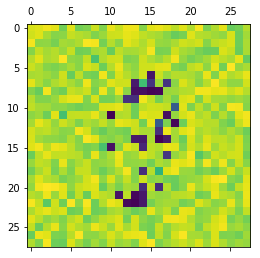

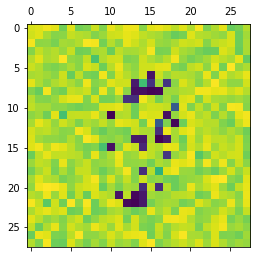

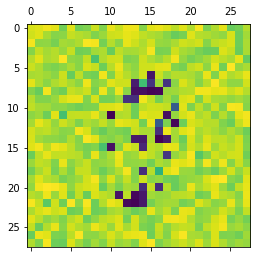

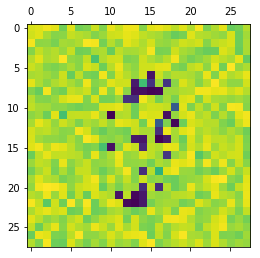

In [67]:
for i in range(10): 
    plt.matshow(image_mean[i, :, :].detach())

In [12]:
### Check things run

In [13]:
# check encoder 

latent_means, latent_std, free_class_weights = \
    vae.encoder(data[0])
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim

assert free_class_weights.shape[0] == batchsize
assert free_class_weights.shape[1] == n_classes 


In [14]:
z_ind = torch.argmax(free_class_weights, dim = 1)

In [15]:
z_ind

tensor([ 2,  2,  2,  2,  2,  2,  5,  2,  9,  9,  2,  2,  9,  2,
         2,  2,  2,  2,  9,  2])

In [16]:
# check one hot encoding 

one_hot_z = common_utils.get_one_hot_encoding_from_int(z_ind, 10)

seq = torch.Tensor([i for i in range(n_classes)])

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [17]:
image_mean, image_std = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [18]:
# check loss goes through

In [19]:
vae.loss(data[0])

tensor(1656.3547)

# Check gradient works 

In [20]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [21]:
vae_params0 = get_vae_params(vae)

In [22]:
assert np.any(np.isnan(vae_params0)) == False

In [23]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [24]:
loss = vae.loss(data[0])
print(loss)

tensor(1655.6113)


In [25]:
loss.backward()
optimizer.step()

In [26]:
vae_params1 = get_vae_params(vae)

In [27]:
assert np.any(np.isnan(vae_params1)) == False

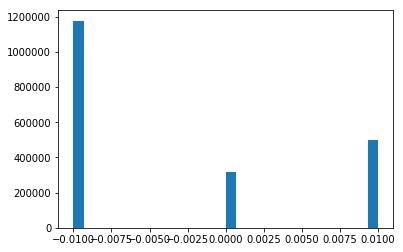

In [28]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [29]:
loss = vae.loss(data[0])

In [30]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [31]:
from torch.utils.data.sampler import Sampler

In [32]:
trainloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=train_set, 
                                                       propn_sample=0.001)

testloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=test_set, 
                                                       propn_sample=0.001)

In [33]:
len(train_loader.dataset)

60000

In [34]:
vae.train_module(trainloader_subs, testloader_subs, 
                 n_epoch = 5, 
                print_every = 2, 
                outfile = './test')

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 1
  * init train recon loss: 0.5448997021;
  * init test recon loss: 0.5487380624;
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
[1] loss: 0.1817598045  	[0.4 seconds]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
[2] loss: 0.02134082653  	[0.5 seconds]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 1
  * train recon loss: 0.005951912608;
  * test recon loss: 0.005426646676;
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
[3] loss: 0.003752589924  	[0.6 seconds]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
[4] loss: 0.002013224876  	[0.7 seconds]
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 1
  * train recon loss: 0.001051260275;
  * test recon loss: 0.001159751904;
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
[5] loss: 0.0006263965624  	[0.6 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final



In [35]:
# check reloading

In [36]:
reload_vae = vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [37]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [38]:
reload_vae.eval_vae(trainloader_subs)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6


tensor(1.00000e-05 *
       7.9501)